In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import gstools as gs
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import patches
import seaborn as sns
import warnings
import os

from utils.visualization_nonlinear_forward_pumpingtest import *
from utils.MC_nonlinear_forward_pumpingtest import *
from utils.DGSA_light import DGSA_light

from inversion_methods.nonlinear_inverse_theta_jointML import *
from inversion_methods.nonlinear_inverse_m_ES import *
from inversion_methods.local_inversion_localPCA import *

plt.rcParams.update({'font.size': 15})
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
path = os.getcwd()
subpath = '/examples/case2_nonlinear_forward_pumping_test/'

# Load and visualize observed data

In [3]:
num_x = 100
num_y = 100

# observed data
d_obs = np.load(path+subpath+'d_obs.npy').reshape(70,5)[:,0]

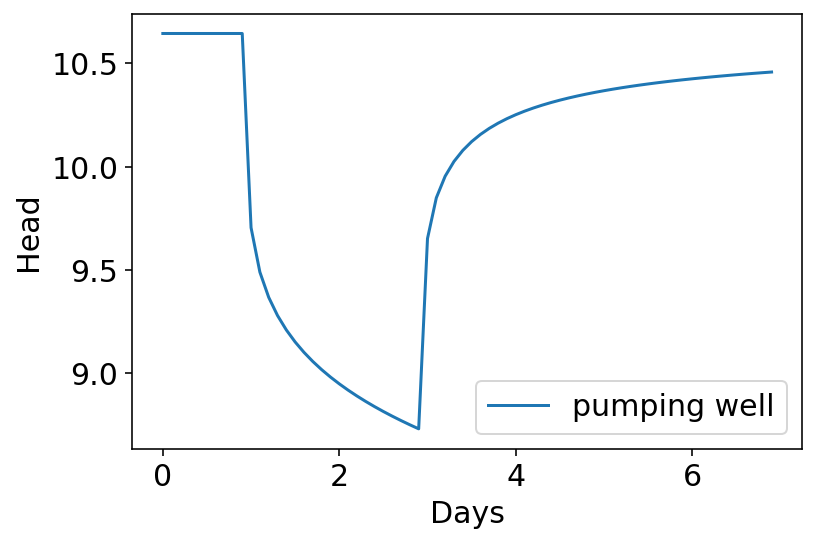

In [4]:
visualize_one_d(d_obs)

## Sneak peek: true model variables

In [5]:
# true global variable, theta_true
theta_name = ['mean', 'variance', 'max_range', 'min_range', 'anisotropy', 'head_west']
theta_true = np.load(path+subpath+'theta_true.npy')
# true spatial variable, m_true
m_true = np.load(path+subpath+'m_true.npy')

       mean  variance  max_range  min_range  anisotropy  head_west
theta  -1.6       0.3       20.0        7.0       120.0       11.0


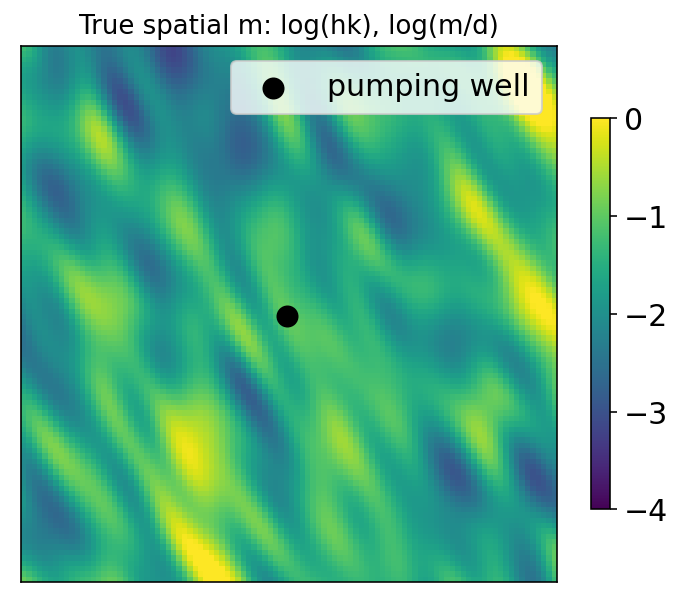

In [6]:
print_theta(theta_true)
visualize_one_m(m_true,vmin = -4,vmax = 0,title = 'True spatial m: log(hk), log(m/d)')

# Monte Carlo sampling: m, theta, d

In [7]:
# MC sampled global variable, theta
theta = np.load(path+subpath+'theta.npy')
# MC sampled spatial variable, m
m = np.load(path+subpath+'m.npy')
# MC sampled spatial variable, d
d = np.load(path+subpath+'d.npy')

# find the success index modflow
success_index_modflow = np.unique(np.where(~np.isnan(d))[1])
d = d[:,success_index_modflow]
m = m[success_index_modflow,:,:]
theta = theta[success_index_modflow,:]
d = d.reshape(70,5,-1)[:,0,:]

In [8]:
# visualize theta
print_theta_multiple(theta)

             mean  variance  max_range  min_range  anisotropy  head_west
theta_1 -1.902373  0.430102  26.224020   8.861379   70.591133  11.524813
theta_2 -1.569621  0.367862  17.703041  12.124766    7.408186  10.124884
theta_3 -1.794473  0.161740  20.835347  10.809853  166.194102  11.472230
theta_4 -1.910234  0.417275  15.564003   9.631377   73.122295  11.110236
theta_5 -2.152690  0.308976  15.176816  14.436460  169.970793  11.877284
theta_6 -1.708212  0.786635  29.944018  12.423964  130.090408  11.702856
theta_7 -2.124826  0.200465  22.322950  14.444667  165.297591   8.677102
theta_8 -1.216454  0.229313  20.580371  13.026061  148.188157  10.319856


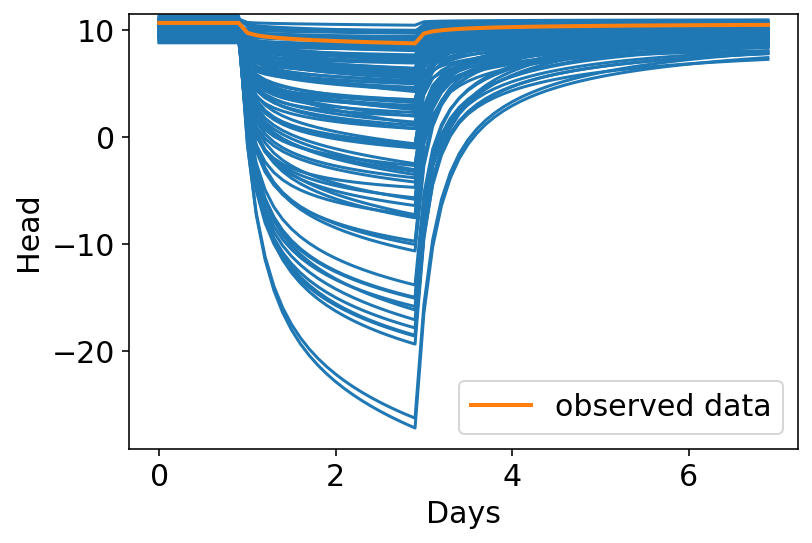

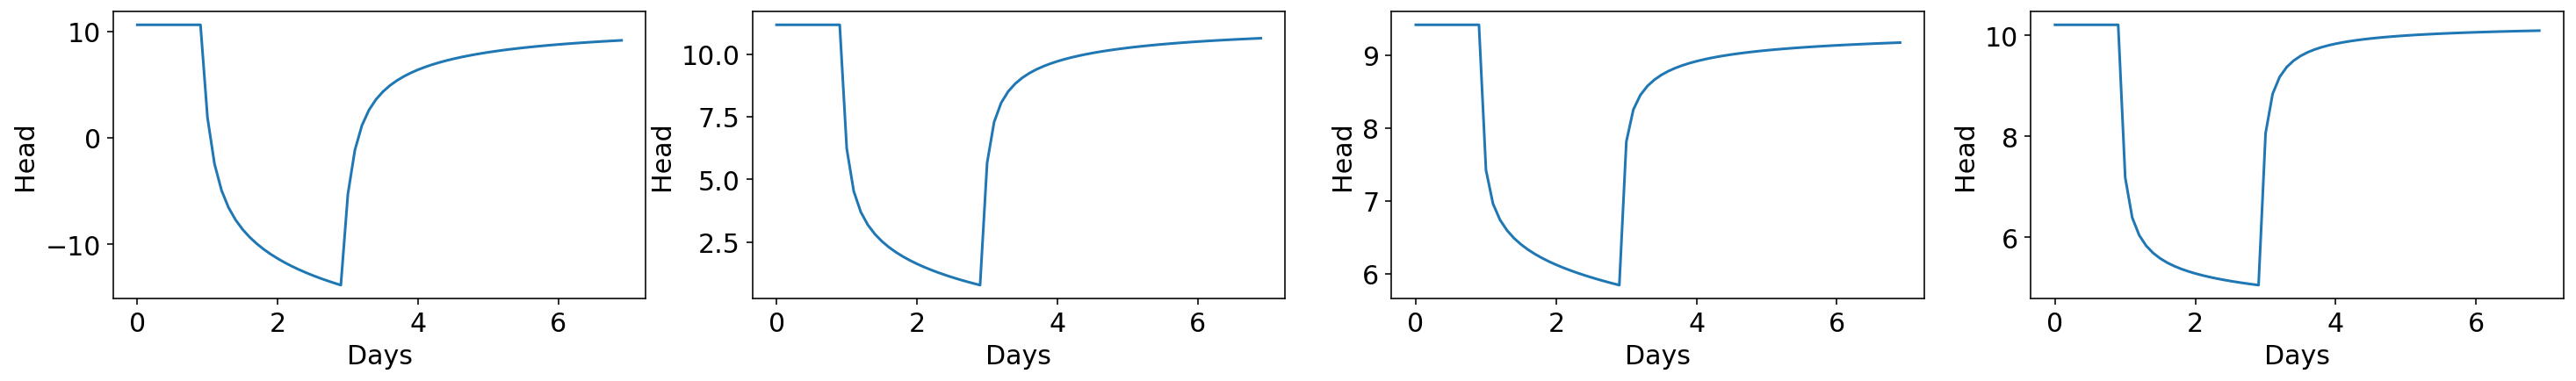

In [9]:
# visualize d and d_obs
visualize_ensemble_d(np.delete(d,np.unique(np.where(d<-30)[1]),axis = 1)[:,:100],d_obs)

visualize_multiple_d(d[:,4:], head = 4)

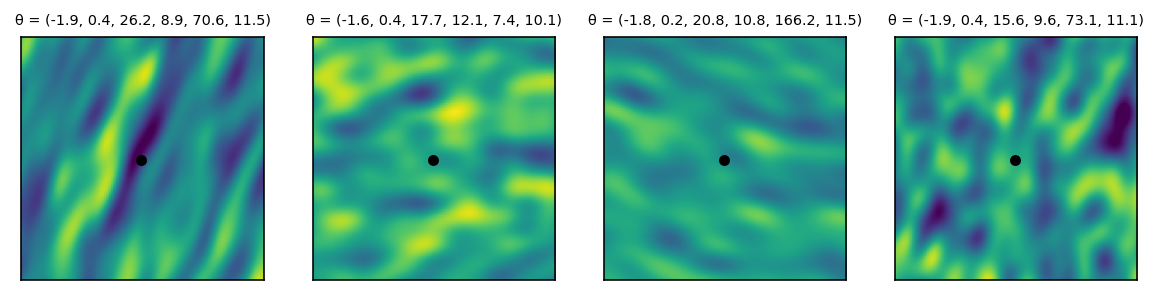

In [10]:
# visualize m
plt.rcParams.update({'font.size': 6})
visualize_multiple_m(m[:,:,:], head = 4,vmin = -4,vmax = 0,theta = theta[:,:])

# Sensitivity analysis on global variable

In [11]:
# Sensitivity analysis on d
dgsa_d_theta = DGSA_light(theta, d.T, theta_name,n_clsters=4,n_boots = 3000)
dgsa_d_theta['name'] = theta_name
dgsa_d_theta['sensitive'] = (dgsa_d_theta[0]>1)*1

100%|██████████| 3000/3000 [00:08<00:00, 356.02it/s]


Text(0.5, 1.0, 'Sensitivity analysis: observed drawdown curves')

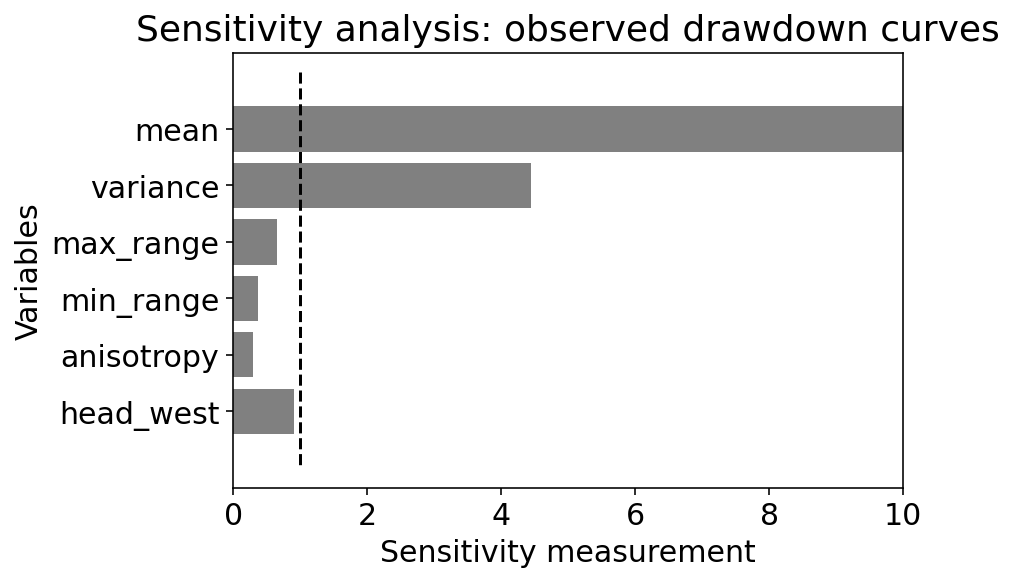

In [12]:
plt.rcParams.update({'font.size': 15})
sns.barplot(x = 0,y = 'name', data=dgsa_d_theta,color = 'grey')
plt.vlines(x = 1, ymin = -1, ymax = len(theta_name),color = 'black',linestyle = '--')
plt.xlabel('Sensitivity measurement')
plt.ylabel('Variables')
plt.xlim(0,10)
plt.title('Sensitivity analysis: observed drawdown curves')

# Hierarchical Bayes: inverse global variable

In [13]:
from sklearn.decomposition import PCA

# PCA on drawdown curve
num_d = d.shape[0]
num_pcs = d.shape[0]
pca = PCA(n_components=num_pcs)
pca.fit(d.T)
d_pcs = pca.transform(d.T)
d_obs_pcs = pca.transform(d_obs.reshape(1,num_d)).T

pc_cutoff = np.where(np.cumsum(pca.explained_variance_ratio_)>1-1e-10)[0][0]

In [14]:
prior_min_theta = np.array([-3,0.1,15,5,0, 8])
prior_max_theta = np.array([-1,1,30,15,180,12]) 

# ML dimension reduction
S_d, S_d_obs,pred_train, y_train, pred_test,y_test,history = ML_dimension_reduction(d_pcs[:,:pc_cutoff], 
                                                                                    d_obs_pcs[:pc_cutoff,:], 
                                                                                    theta, 
                                                                                    prior_min_theta, 
                                                                                    prior_max_theta,
                                                                                    custom_loss_function_case2,
                                                                                    learning_rate = 2e-3, 
                                                                                    num_input = 30,
                                                                                    num_epoch = 1000,
                                                                                    batch_size = 200)

0epoch [00:00, ?epoch/s]

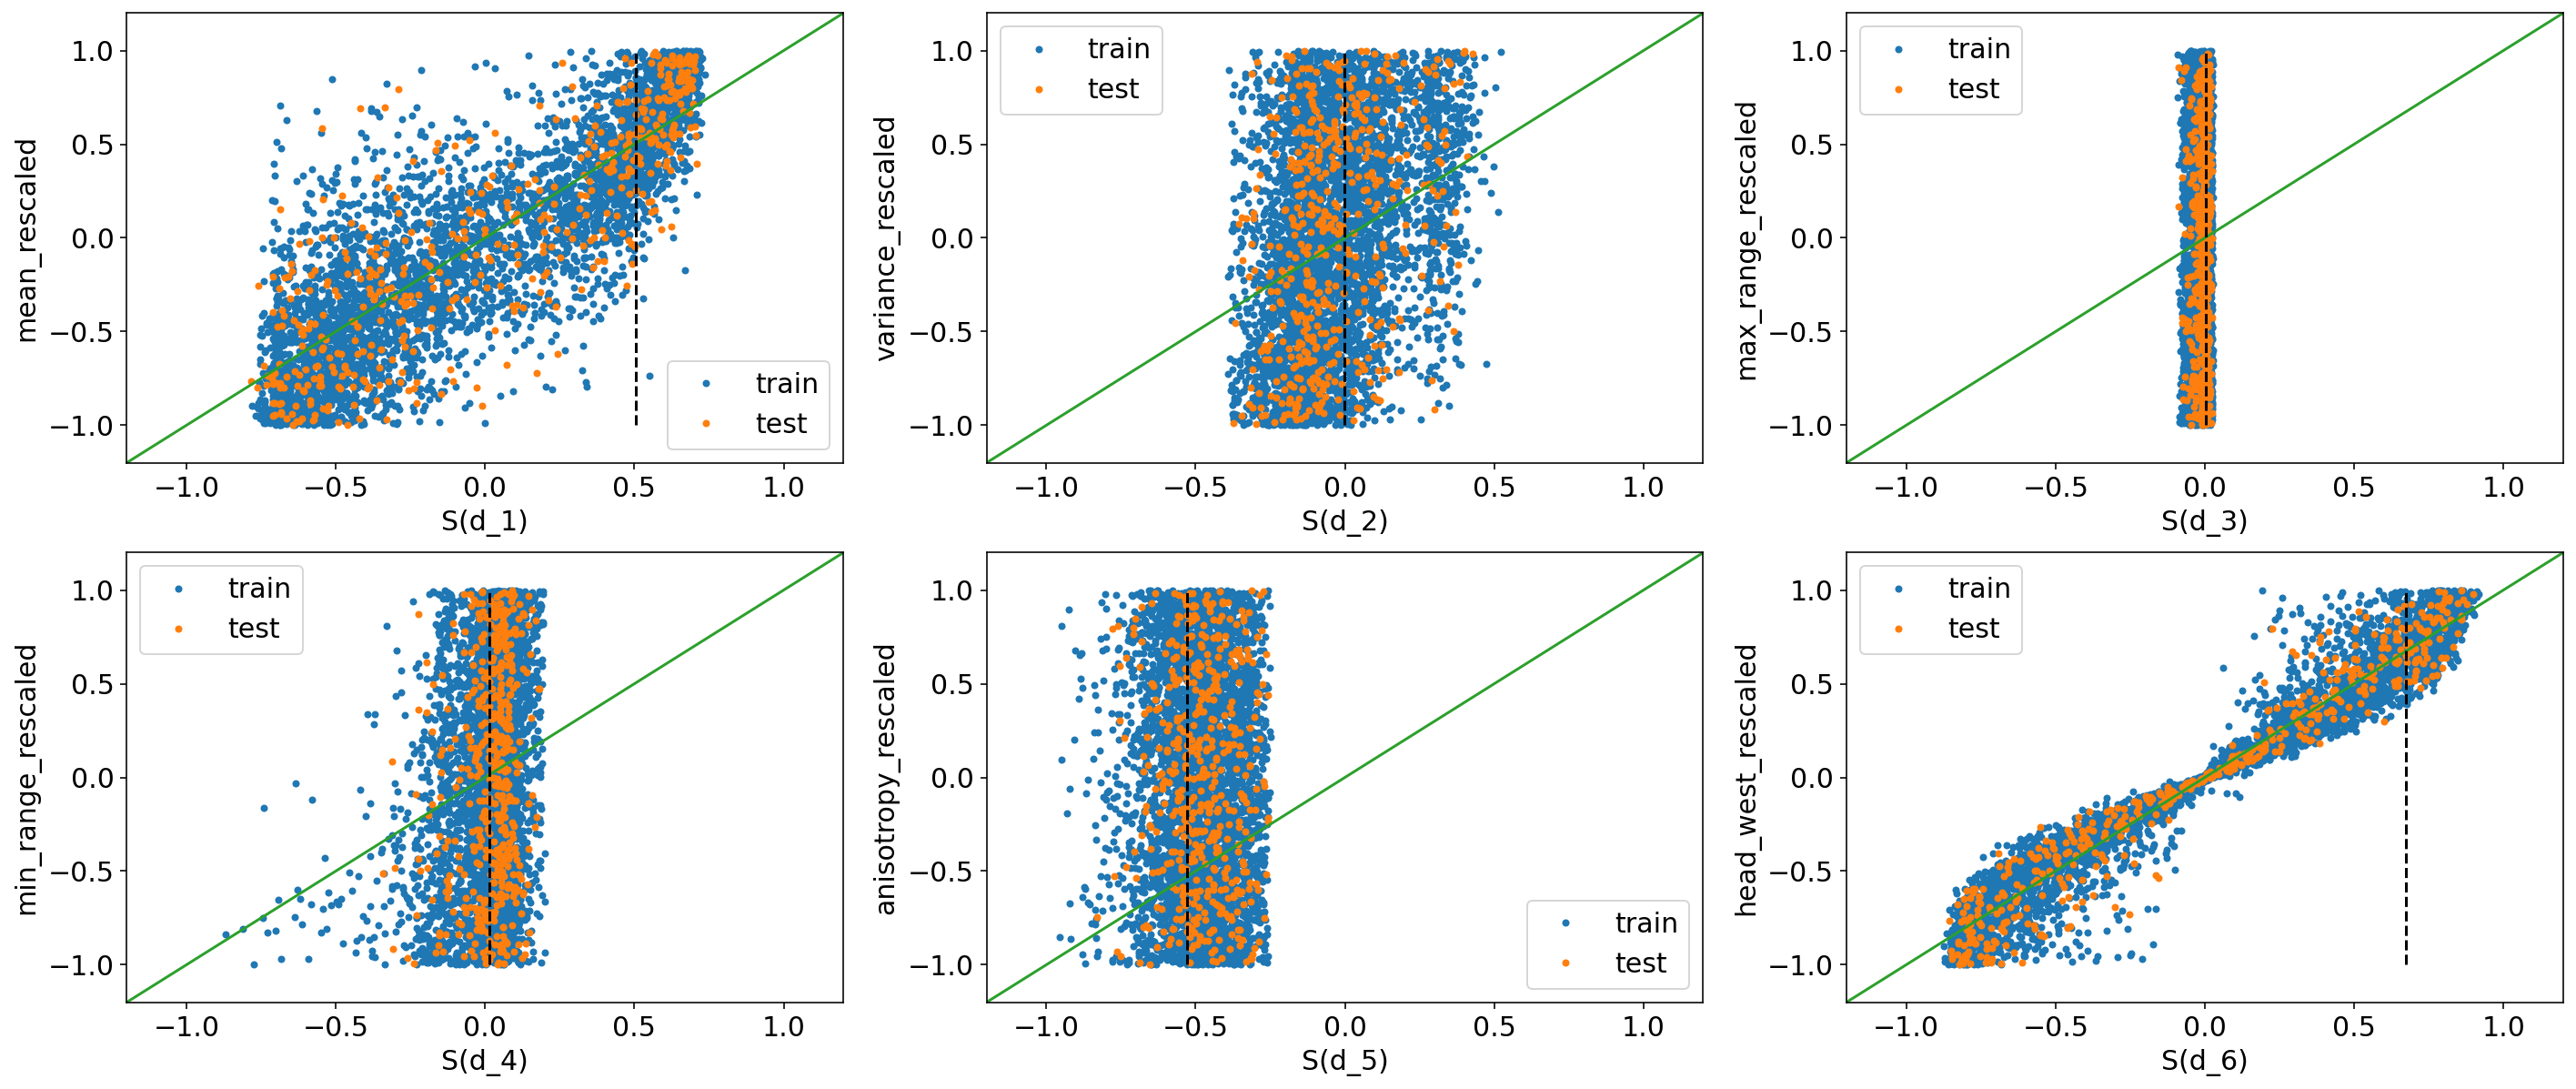

In [15]:
# visualize ML dimenison reduction result
ML_dimension_reduction_vis(pred_train, y_train, pred_test, y_test, S_d_obs, theta_name)

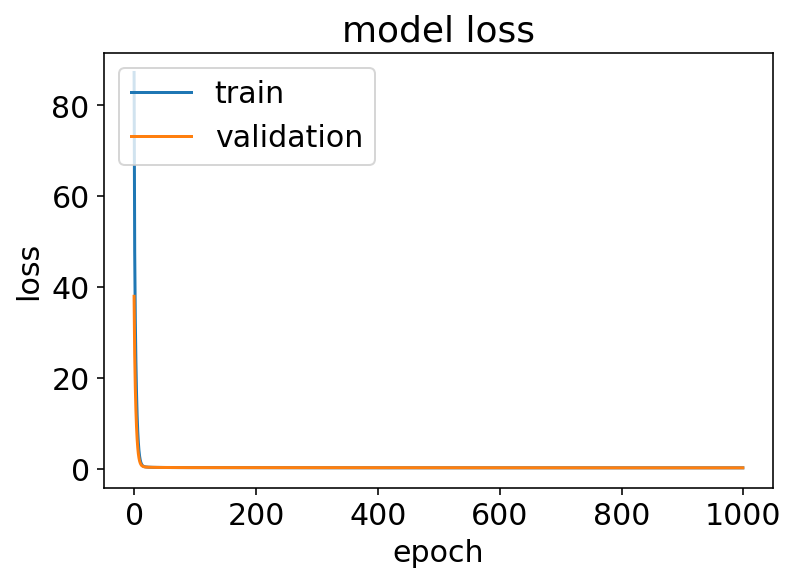

In [16]:
# visualize training history
history_plot(history)

In [17]:
# posterior sampling from joint distribution
theta_pos_MC = posterior_global_samples_jointML(S_d, S_d_obs, theta, prior_min_theta, prior_max_theta)

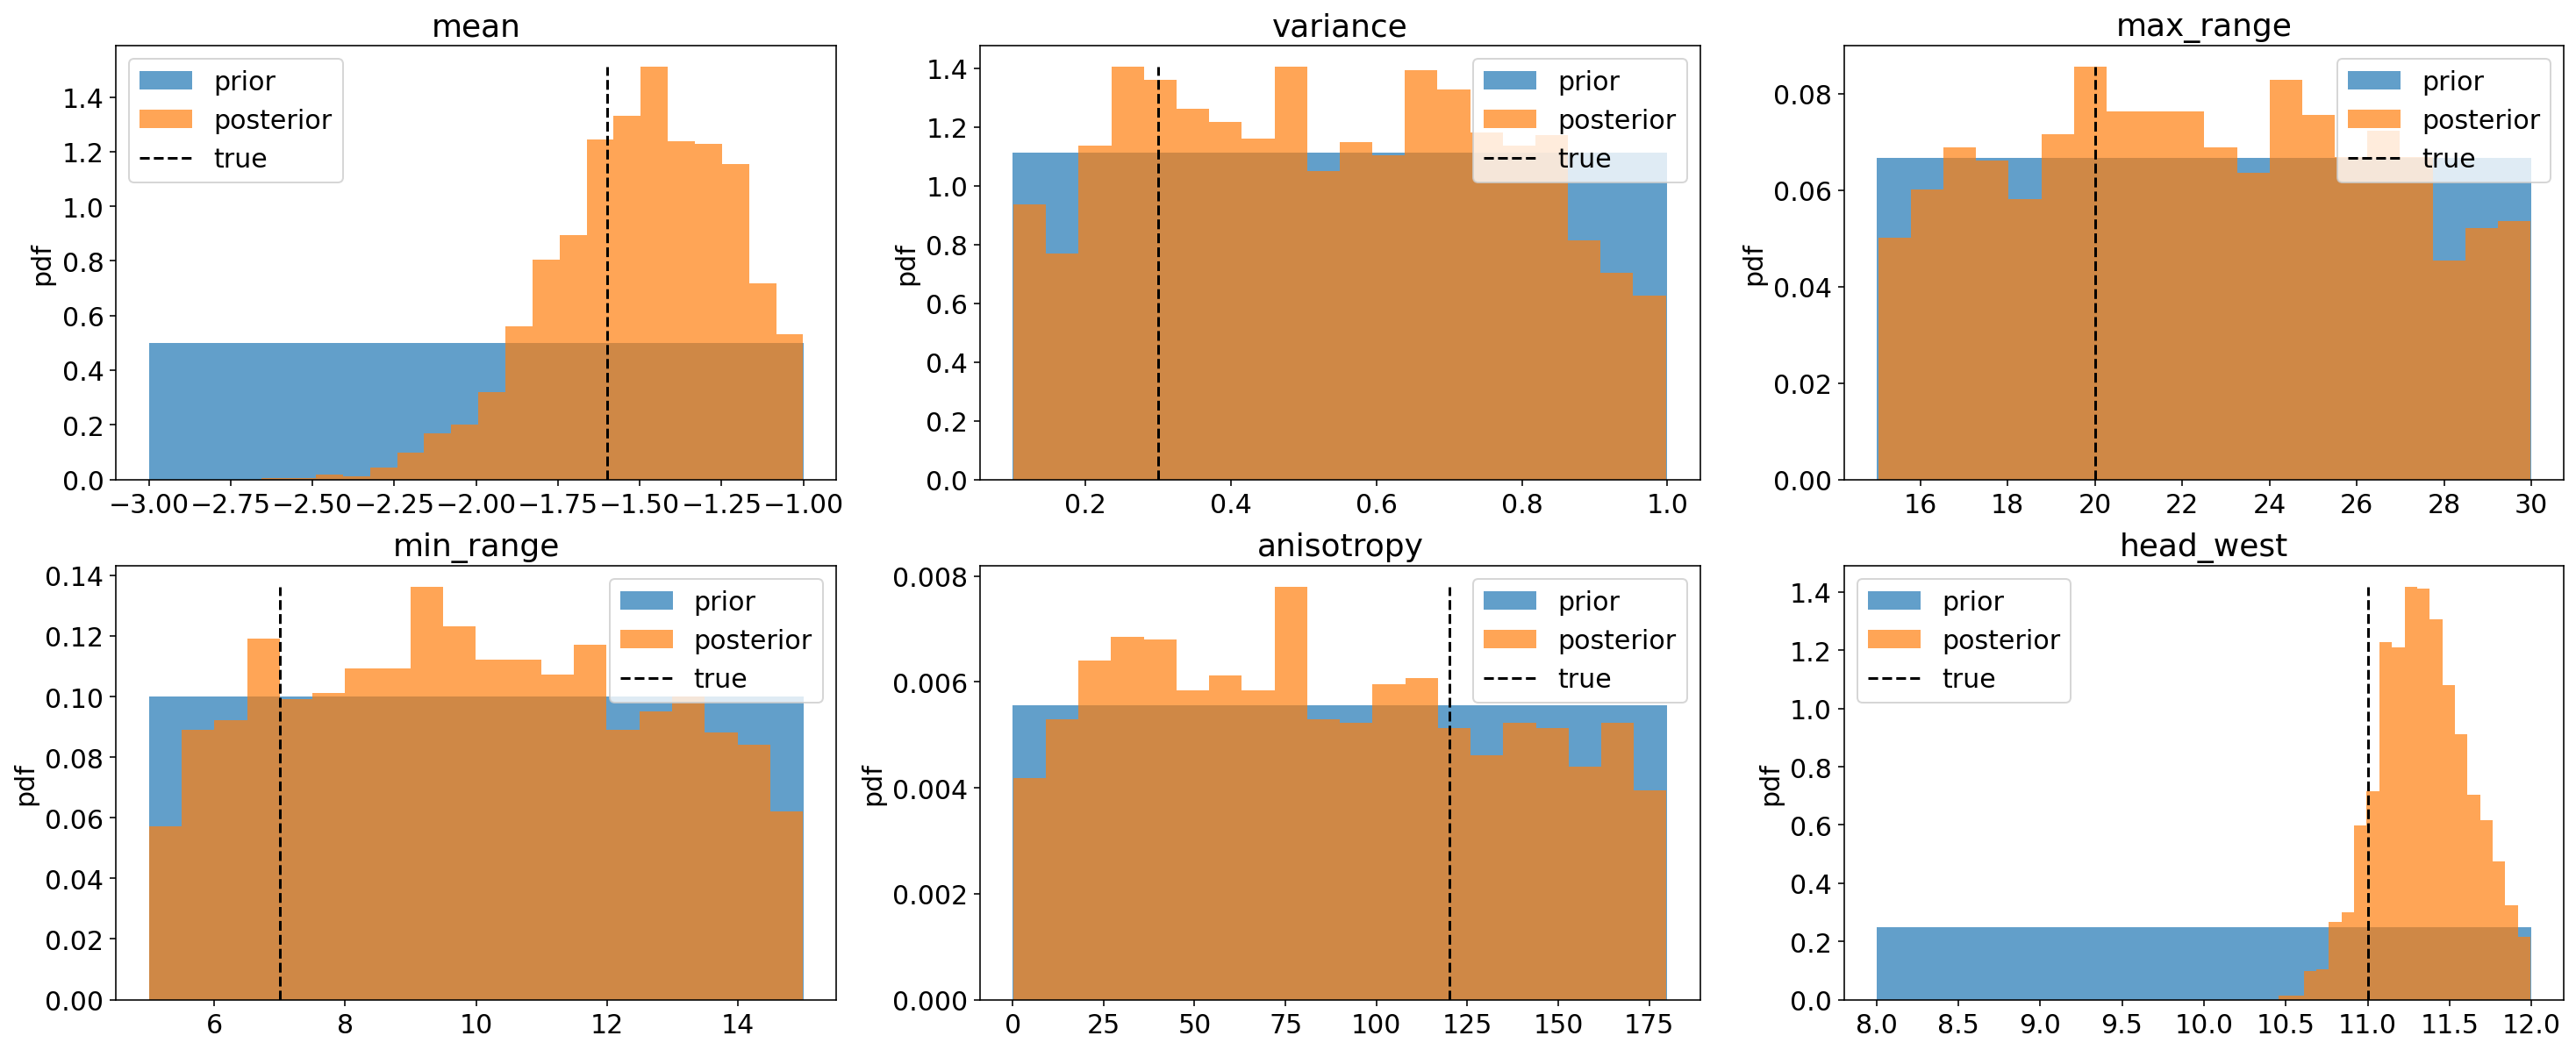

In [18]:
# visualize prior and posterior
prior_pos_theta(theta, theta_pos_MC, theta_true, theta_name)

In [19]:
# You can save your inversion result and reload it

# np.save('saved_inverse_results/posterior_case2.npy',theta_pos_MC)
theta_pos_MC = np.load('saved_inverse_results/posterior_theta_ML_case2.npy')

# Hierarchical Bayes: inverse spatial variable

**The goal is to compare local spatial inversion and global spatial inversion**.

Random sample the posterior global varible $\theta ~ p(\theta|d_{obs})$ and solve the spatial inversion $p(m|\theta,d_{obs})$

In [20]:
real_idx = 0
theta_pos_real = theta_pos_MC[:,real_idx]

In [21]:
print_theta(theta_pos_real)

           mean  variance  max_range  min_range  anisotropy  head_west
theta -1.599015  0.227902  16.503622   8.358117  165.117007  11.791943


Sample 100 realizations of $m$ given fixed $\theta$

In [22]:
# takes about 1 mins
num_pos_sample = 100
loghk_posterior = generate_m_MC_same_theta(theta_pos_real,num_sample = num_pos_sample)

100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


Run non-linear forward modeling, modflow simulation: 

In [23]:
pumping_rate = -10.
well_location = [49,49]
observed_wells = [[41,41],[57,57],[41,57],[57,41]] # we didn't use the observed wells for inversion

In [24]:
# takes around 5 minutes

drawdown_pos = np.zeros((70*5,num_pos_sample))
# forward modeling
for i in tqdm(range(num_pos_sample)):
    fname = 'pumping_test_pos'
    hwest = theta_pos_real[-1]
    loghk = loghk_posterior[i,:,:]
    drawdown_curves = run_modflow(fname, nrow, ncol, 
                                  hwest, loghk, pumping_rate, 
                                  well_location, observed_wells, 
                                  path = modflowpath)
    drawdown_pos[:,i] = drawdown_curves

100%|██████████| 100/100 [05:16<00:00,  3.16s/it]


In [25]:
drawdown_pos = drawdown_pos.reshape(70,5,-1)[:,0,:]

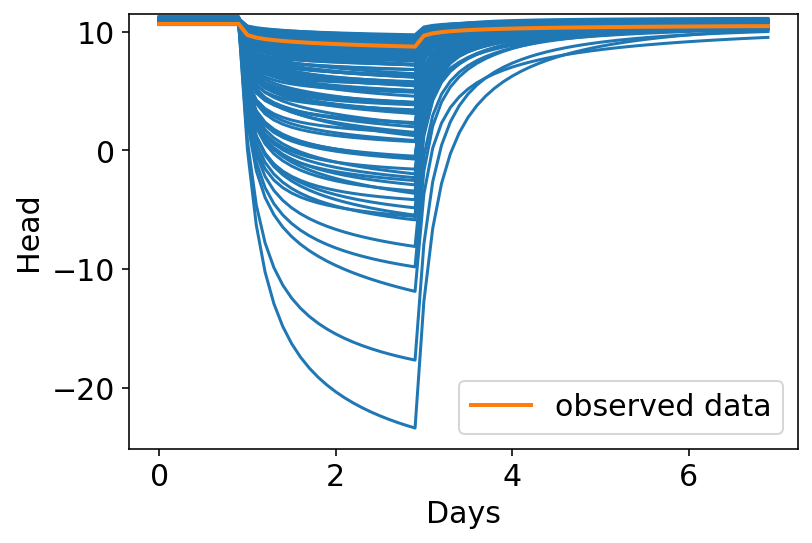

In [26]:
visualize_ensemble_d(np.delete(drawdown_pos,np.unique(np.where(drawdown_pos<-30)[1]),axis = 1)[:,:100],d_obs)

Visualize 100 realizations of $m$ given fixed $\theta$

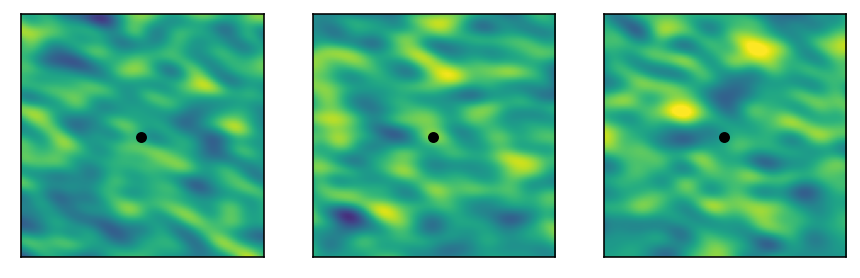

In [27]:
visualize_multiple_m(loghk_posterior.reshape(num_pos_sample,100,100),vmin = -4, vmax = 0,head = 3)

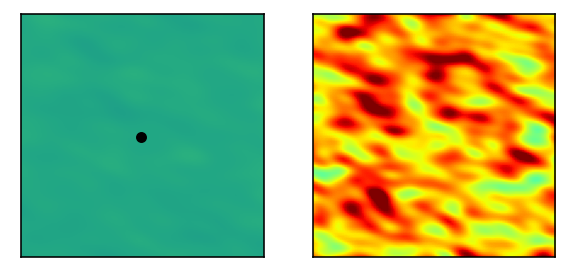

In [28]:
visualize_mean_var_MC(loghk_posterior,32,36,vmin = -4, vmax = 0)

## Sensitivity analysis

### Sensitivity analysis: the global principal components

In [29]:
global_PCA_result = PCA_fast(loghk_posterior.reshape(-1,10000).T)

In [30]:
# pos data_PCA
pca = PCA(n_components=70)
pca.fit(drawdown_pos.T)
d_pos_pcs = pca.transform(drawdown_pos.T)
d_obs_pos_pcs = pca.transform(d_obs.reshape(1,num_d)).T

In [31]:
# Sensitivity analysis: global PC
num_PC_sensitive = 10
globalPC_name = ['PC_'+str(i) for i in np.arange(1,num_PC_sensitive+1)]
dgsa_d_global_m = DGSA_light(global_PCA_result['pc_scores'][:num_PC_sensitive,:].T, drawdown_pos.T, 
                             globalPC_name,n_clsters=4,n_boots = 3000)
dgsa_d_global_m['name'] = globalPC_name
dgsa_d_global_m['sensitive'] = (dgsa_d_global_m[0]>1)*1

100%|██████████| 3000/3000 [00:02<00:00, 1381.23it/s]


(0.0, 1.5)

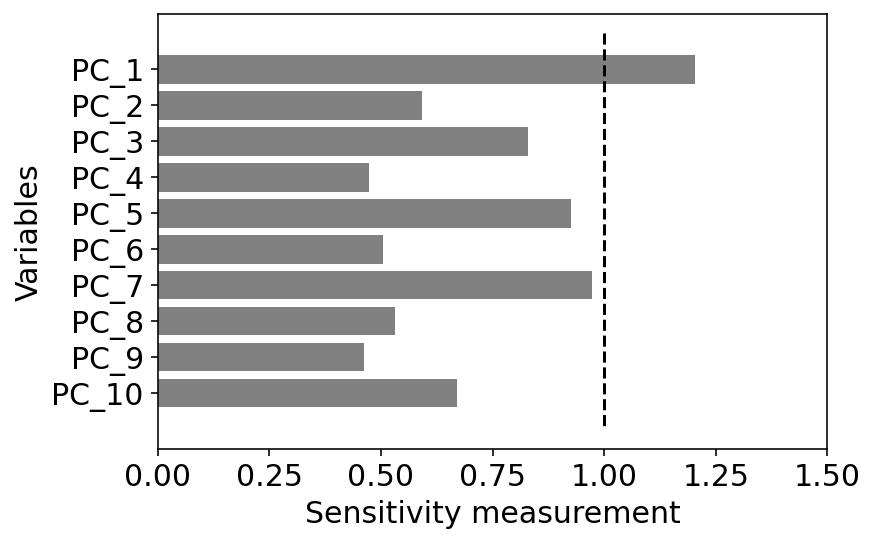

In [32]:
plt.rcParams.update({'font.size': 15})
sns.barplot(x = 0,y = 'name', data=dgsa_d_global_m,color = 'grey')
plt.vlines(x = 1, ymin = -1, ymax = len(globalPC_name),color = 'black',linestyle = '--')
plt.xlabel('Sensitivity measurement')
plt.ylabel('Variables')
plt.xlim(0,1.5)
#plt.title('Sensitivity analysis: observed drawdown curves')

### Sensitivity analysis: the local principal components

In [33]:
num_PC_sensitive = 10

local_boundary = 18
local_indicator = np.zeros((nrow,ncol))
local_indicator[:] = np.nan
local_indicator[np.int(50-local_boundary):np.int(50+local_boundary),np.int(50-local_boundary):np.int(50+local_boundary)] = 1

In [34]:
global_PCA_result,local_PCA_result,_,_ = local_PCA(loghk_posterior.reshape(-1,10000).T, local_indicator, project = True)

In [35]:
# Sensitivity analysis: local PC
localPC_name = ['local_PC_'+str(i) for i in np.arange(1,num_PC_sensitive+1)]
dgsa_d_local_m = DGSA_light(local_PCA_result['pc_scores'][:num_PC_sensitive,:].T,  drawdown_pos.T, 
                            localPC_name,n_clsters=4,n_boots = 3000)
dgsa_d_local_m['name'] = localPC_name
dgsa_d_local_m['sensitive'] = (dgsa_d_local_m[0]>1)*1

100%|██████████| 3000/3000 [00:02<00:00, 1331.79it/s]


(0.0, 1.5)

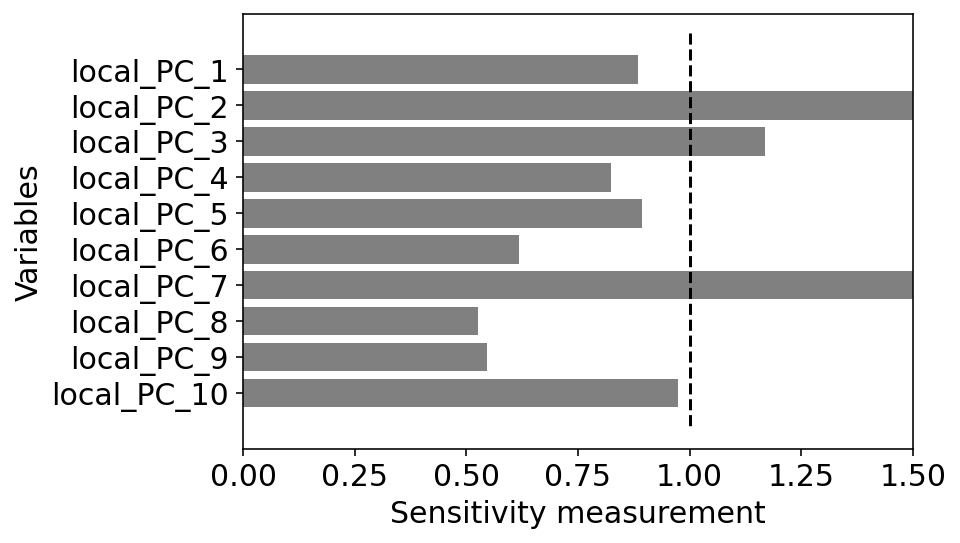

In [36]:
sns.barplot(x = 0,y = 'name', data=dgsa_d_local_m,color = 'grey')
plt.vlines(x = 1, ymin = -1, ymax = len(localPC_name),color = 'black',linestyle = '--')
plt.xlabel('Sensitivity measurement')
plt.ylabel('Variables')
plt.xlim(0,1.5)

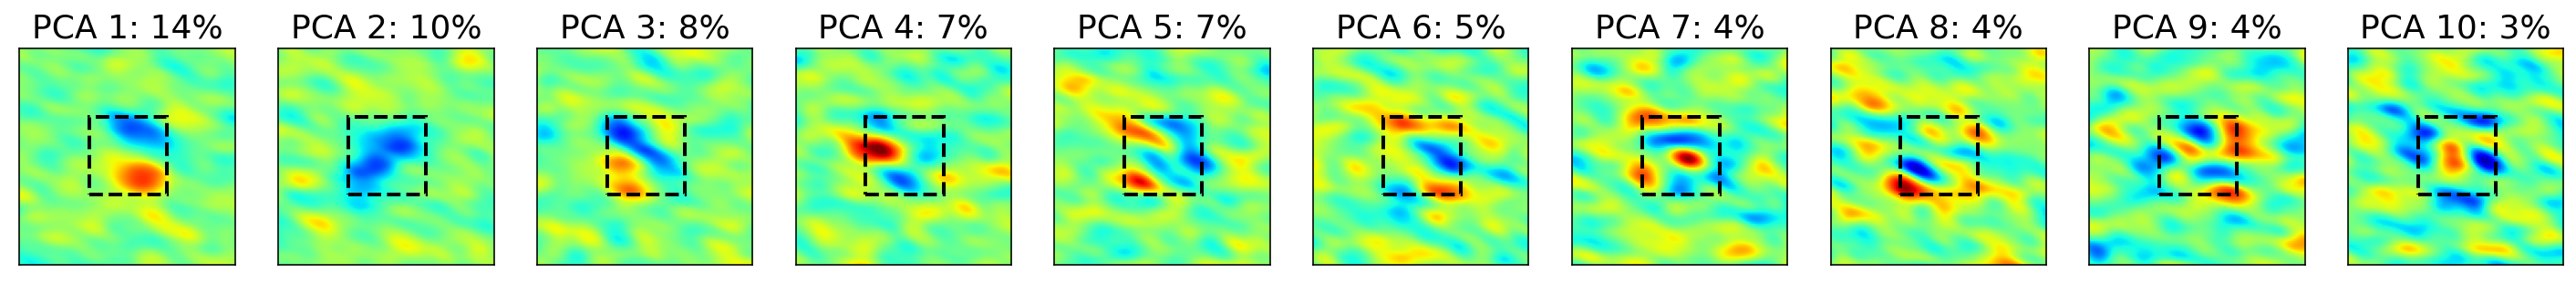

In [37]:
visualize_multiple_pc(local_PCA_result['eigen_vectors_all'].T.reshape(num_pos_sample,100,100)[:,:,:],local_PCA_result,
                      head = 10,
                      vmin = -0.08, vmax = 0.08,cmap = 'jet',rect = True)

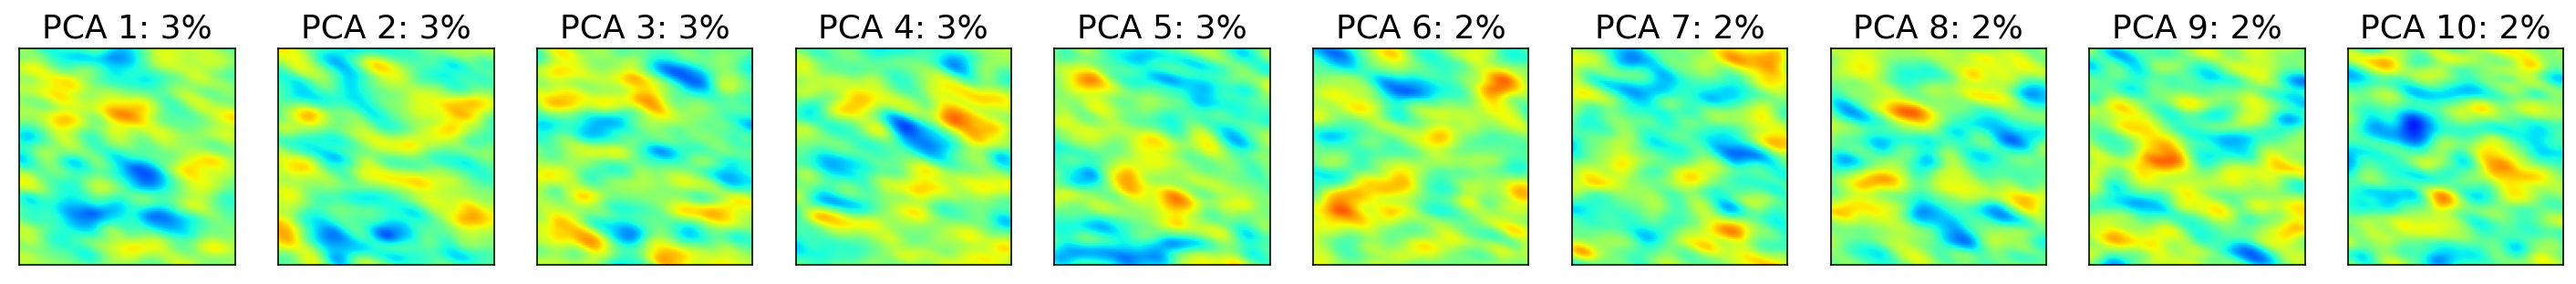

In [38]:
visualize_multiple_pc(global_PCA_result['eigen_vectors'].T.reshape(num_pos_sample,100,100), global_PCA_result,head = 10,
                     vmin = -0.05, vmax = 0.05,cmap = 'jet')

### Find the local area size

In [39]:
# find the local area size
num_PC_sensitive = 20
dgsa_local = np.zeros((13,20))
i = 0
for local_boundary in np.arange(2,51,4):
    local_indicator = np.zeros((nrow,ncol))
    local_indicator[:] = np.nan
    local_indicator[np.int(50-local_boundary):np.int(50+local_boundary),np.int(50-local_boundary):np.int(50+local_boundary)] = 1
    global_PCA_result,local_PCA_result,_,_ = local_PCA(loghk_posterior.reshape(-1,10000).T, local_indicator, project = True)

    # Sensitivity analysis: local PC
    localPC_name = ['local_PC_'+str(i) for i in np.arange(1,num_PC_sensitive+1)]
    dgsa_d_local_m = DGSA_light(local_PCA_result['pc_scores'][:num_PC_sensitive,:].T,  drawdown_pos.T, 
                                localPC_name,n_clsters=4,n_boots = 3000)
    
    dgsa_local[i,:] = dgsa_d_local_m[0]
    i = i+1

100%|██████████| 3000/3000 [00:02<00:00, 1118.14it/s]


Text(0.5, 1.0, '# of sensitive principal components')

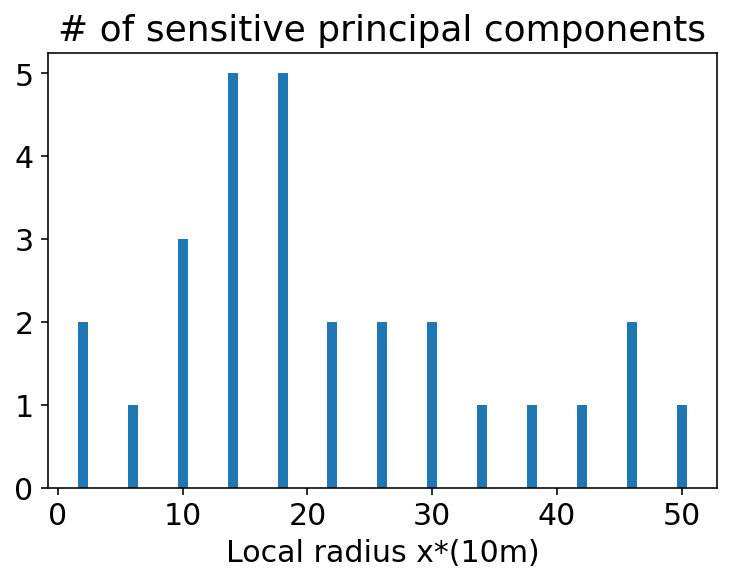

In [40]:
plt.bar(np.arange(2,51,4),np.sum(dgsa_local[:,:10]>1,axis = 1))
plt.xlabel('Local radius x*(10m)')
plt.title('# of sensitive principal components')

# Ensemble smoother: non-linear inversion

In [41]:
# rerun with the reasonable local size 
local_boundary = 18
local_indicator = np.zeros((nrow,ncol))
local_indicator[:] = np.nan
local_indicator[np.int(50-local_boundary):np.int(50+local_boundary),np.int(50-local_boundary):np.int(50+local_boundary)] = 1

global_PCA_result,local_PCA_result,_,_ = local_PCA(loghk_posterior.reshape(-1,10000).T, local_indicator, project = True)

## Inverse the global PCs

In [42]:
# inverse first 30 components
m_pos_global = ensemble_smoother(global_PCA_result['pc_scores'][:30,:],
                                 d_pos_pcs[:100,:10].T,d_obs_pos_pcs[:10,:1])
m_pos_reconstruct_global = reconstruction(global_PCA_result,
                                          pc_scores=np.vstack([m_pos_global,
                                                               global_PCA_result['pc_scores'][30:,:]]),
                                          n_component=num_pos_sample)

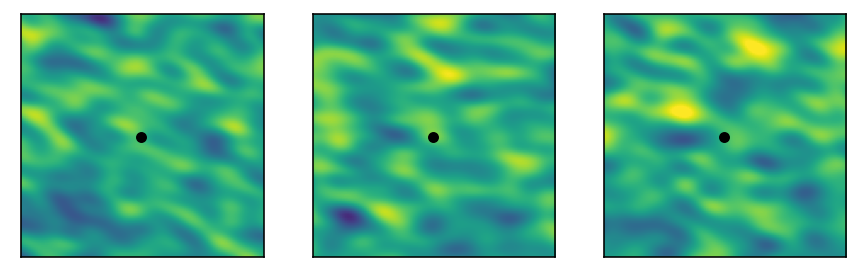

In [43]:
visualize_multiple_m(m_pos_reconstruct_global.T.reshape(-1,100,100)[:,:,:],vmin = -4, vmax = 0,head = 3)

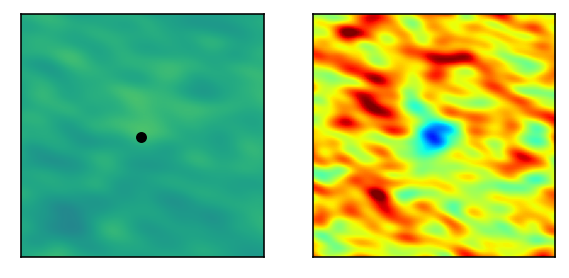

In [44]:
visualize_mean_var_MC(m_pos_reconstruct_global.T,32,36,vmin = -4, vmax = 0)

## Inverse the local PCs

In [45]:
# inverse first 30 components
m_pos_local = ensemble_smoother(local_PCA_result['pc_scores'][:30,:],
                                d_pos_pcs[:100,:10].T,d_obs_pos_pcs[:10,:1])
m_pos_reconstruct_local = reconstruction_localPCA(global_PCA_result,
                                                  local_PCA_result,
                                                  pc_scores=np.vstack([m_pos_local,local_PCA_result['pc_scores'][30:,:]]),
                                                  n_component=num_pos_sample-1)

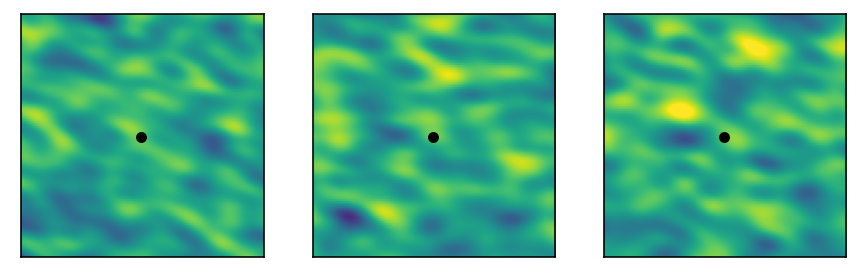

In [46]:
visualize_multiple_m(m_pos_reconstruct_local.T.reshape(-1,100,100)[:,:,:],vmin = -4, vmax = 0,head = 3)

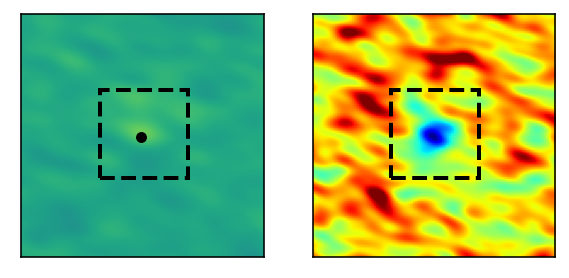

In [47]:
visualize_mean_var_MC(m_pos_reconstruct_local.T,32,36,vmin = -4, vmax = 0,rect = True)

Difference between inversion with global and local PCs

In [48]:
diff_var = np.var(m_pos_reconstruct_global.T,axis = 0)-np.var(m_pos_reconstruct_local.T,axis = 0)

[]

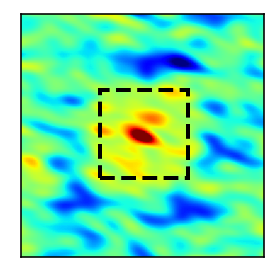

In [49]:
plt.figure(figsize = [10,4])
ax = plt.subplot(1, 4, 1)
ax.imshow(diff_var.reshape(num_x,num_y).T, origin = 'lower', cmap = 'jet', vmin = -0.03, vmax = 0.03)
rect = patches.Rectangle((32,32), 36, 36, linewidth=2,linestyle = 'dashed', edgecolor='black',facecolor='None', label = 'pilot area')
ax.add_patch(rect)
ax.set_xticks([])
ax.set_yticks([])

## Posterior drawdown curves

In [50]:
drawdown_pos_global = np.zeros((70*5,num_pos_sample))

# forward modeling
for i in tqdm(range(num_pos_sample)):
    fname = 'pumping_test_pos_pos'
    hwest = theta_pos_real[-1]
    loghk = m_pos_reconstruct_global.T.reshape(num_pos_sample,100,100)[i,:,:]
    drawdown_curves = run_modflow(fname, nrow, ncol, 
                                  hwest, loghk, pumping_rate, 
                                  well_location, observed_wells, 
                                  path = modflowpath)
    drawdown_pos_global[:,i] = drawdown_curves

100%|██████████| 100/100 [05:20<00:00,  3.20s/it]


In [51]:
drawdown_pos_local = np.zeros((70*5,num_pos_sample))

# forward modeling
for i in tqdm(range(num_pos_sample)):
    fname = 'pumping_test_pos_pos'
    hwest = theta_pos_real[-1]
    loghk = m_pos_reconstruct_local.T.reshape(num_pos_sample,100,100)[i,:,:]
    drawdown_curves = run_modflow(fname, nrow, ncol, 
                                  hwest, loghk, pumping_rate, 
                                  well_location, observed_wells, 
                                  path = modflowpath)
    drawdown_pos_local[:,i] = drawdown_curves

100%|██████████| 100/100 [04:55<00:00,  2.96s/it]


In [52]:
drawdown_pos_global = drawdown_pos_global.reshape(70,5,-1)[:,0,:]
drawdown_pos_local = drawdown_pos_local.reshape(70,5,-1)[:,0,:]

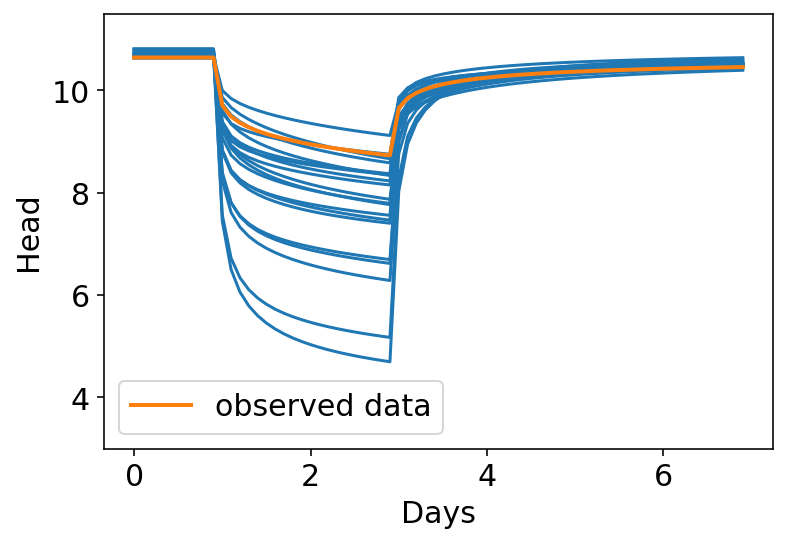

In [53]:
visualize_ensemble_d(drawdown_pos_global.reshape(70,5,-1)[:,0,:],d_obs,ymin = 3)

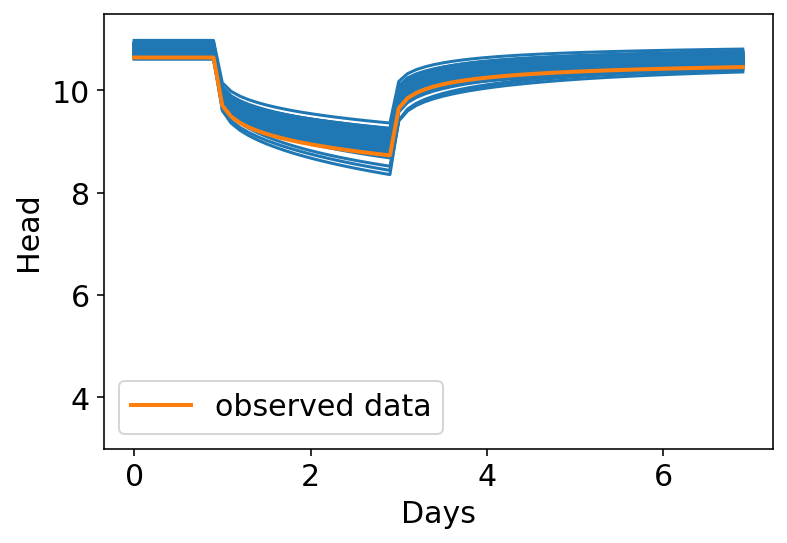

In [54]:
visualize_ensemble_d(drawdown_pos_local,d_obs,ymin = 3)

# ES-MDA: many ES iterations for non-linear inversion

In [55]:
def ES_multiple_iteration(loghk_posterior, theta_current, local_indicator, iter_times = 4, local = True):
    num_pos_sample = 100
    drawdown_pos_list = []
    loghk_list = []
    loghk_list.append(loghk_posterior)
    
    for num_iter in range(iter_times):
        drawdown_pos = np.zeros((70*5,num_pos_sample))

        # forward modeling
        for i in tqdm(range(num_pos_sample)):
            fname = 'pumping_test'
            hwest = theta_current[-1]
            loghk = loghk_posterior[i,:,:]
            drawdown_curves = run_modflow(fname, nrow, ncol, 
                                          hwest, loghk, pumping_rate, 
                                          well_location, observed_wells, 
                                          path = modflowpath)
            drawdown_pos[:,i] = drawdown_curves
        drawdown_pos = drawdown_pos.reshape(70,5,-1)[:,0,:]
        drawdown_pos_list.append(drawdown_pos)
        
        # PCA on drawdown
        pca = PCA(n_components=70)
        pca.fit(drawdown_pos.T)
        d_pos_pcs = pca.transform(drawdown_pos.T)
        d_obs_pos_pcs = pca.transform(d_obs.reshape(1,num_d)).T
        
        # PCA
        global_PCA_result,local_PCA_result,_,_ = local_PCA(loghk_posterior.reshape(-1,10000).T, 
                                                           local_indicator, project = True)
        # inverse 
        if local:
            m_pos_local = ensemble_smoother(local_PCA_result['pc_scores'][:30,:],
                                            d_pos_pcs[:100,:10].T,d_obs_pos_pcs[:10,:100])
            m_pos_reconstruct_local = reconstruction_localPCA(global_PCA_result,
                                                              local_PCA_result,
                                                              pc_scores=np.vstack([m_pos_local,local_PCA_result['pc_scores'][30:,:]]),
                                                              n_component=num_pos_sample-1)
            loghk_posterior = m_pos_reconstruct_local.T.reshape(num_pos_sample,100,100)
            loghk_list.append(loghk_posterior)
        else:
            m_pos_global = ensemble_smoother(global_PCA_result['pc_scores'][:30,:],
                                             d_pos_pcs[:100,:10].T,
                                             d_obs_pos_pcs[:10,:100])
            m_pos_reconstruct_global = reconstruction(global_PCA_result,
                                                      pc_scores=np.vstack([m_pos_global,
                                                                           global_PCA_result['pc_scores'][30:,:]]),
                                                      n_component=num_pos_sample)
            loghk_posterior = m_pos_reconstruct_global.T.reshape(num_pos_sample,100,100)
            loghk_list.append(loghk_posterior)
    
    # posterior data after multiple inversions
    drawdown_pos = np.zeros((70*5,num_pos_sample))

    # forward modeling
    for i in tqdm(range(num_pos_sample)):
        fname = 'pumping_test'
        hwest = theta_current[-1]
        loghk = loghk_posterior[i,:,:]
        drawdown_curves = run_modflow(fname, nrow, ncol, 
                                      hwest, loghk, pumping_rate, 
                                      well_location, observed_wells, 
                                      path = modflowpath)
        drawdown_pos[:,i] = drawdown_curves
    drawdown_pos = drawdown_pos.reshape(70,5,-1)[:,0,:]
    drawdown_pos_list.append(drawdown_pos)
    
    return loghk_list,drawdown_pos_list

4 iterations

In [56]:
loghk_list_global,drawdown_pos_list_global = ES_multiple_iteration(loghk_posterior, theta_pos_real, local_indicator, 
                                                                   iter_times = 4, local = False)

100%|██████████| 100/100 [05:07<00:00,  3.08s/it]


In [57]:
loghk_list_local,drawdown_pos_list_local = ES_multiple_iteration(loghk_posterior, theta_pos_real, local_indicator, 
                                                                 iter_times = 4, local = True)

100%|██████████| 100/100 [05:32<00:00,  3.32s/it]


Posterior drawdown curves

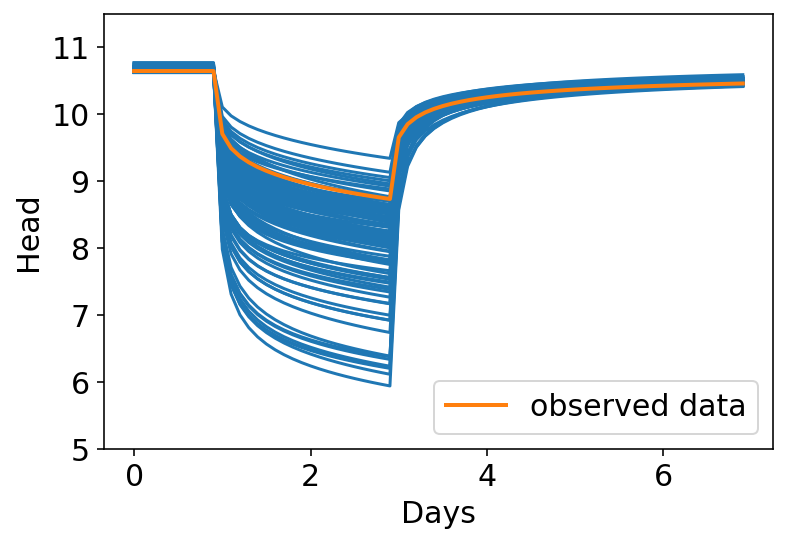

In [58]:
visualize_ensemble_d(drawdown_pos_list_global[4],d_obs,ymin = 5)

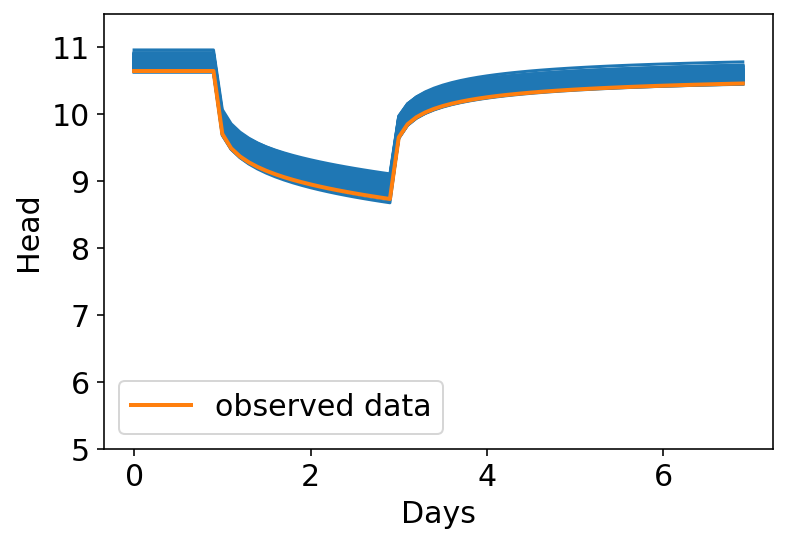

In [59]:
visualize_ensemble_d(drawdown_pos_list_local[4],d_obs,ymin = 5)

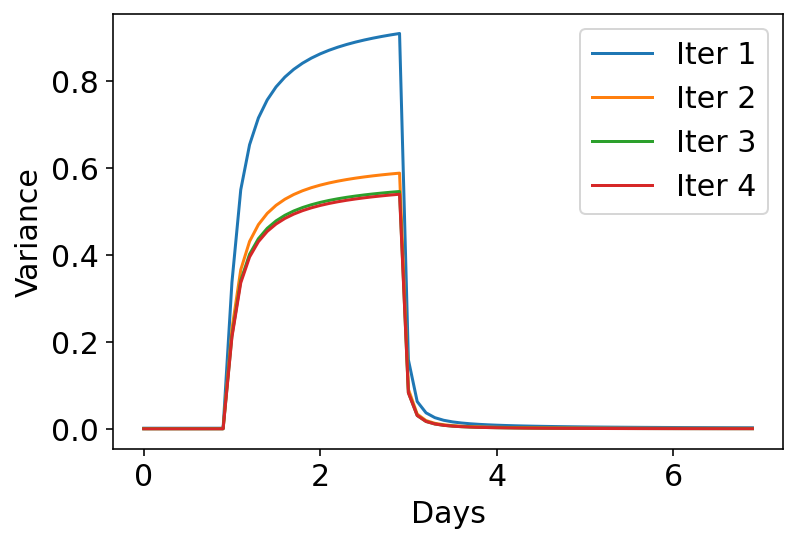

In [60]:
for i in range(4):
    plt.plot(np.arange(0,70)/10,np.var(drawdown_pos_list_global[i+1],axis = 1),label = 'Iter '+str(i+1))

plt.ylabel('Variance')
plt.xlabel('Days')
plt.legend()

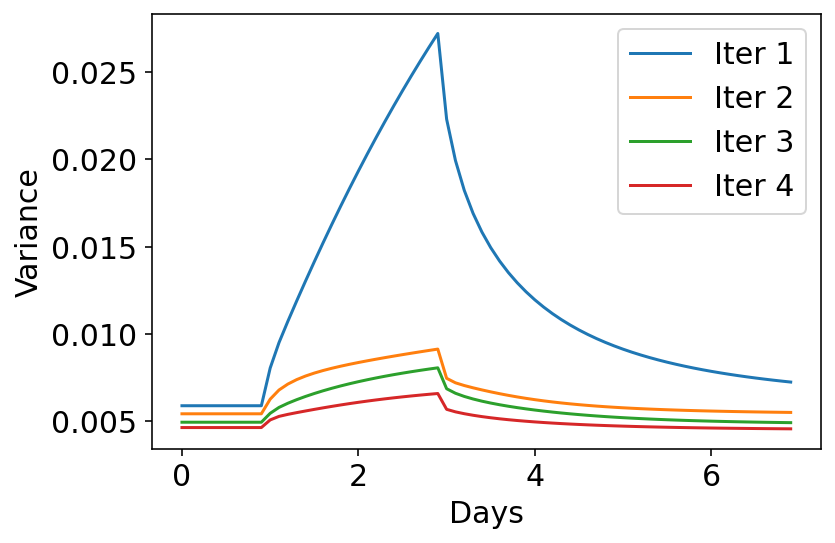

In [61]:
for i in range(4):
    plt.plot(np.arange(0,70)/10,np.var(drawdown_pos_list_local[i+1],axis = 1),label = 'Iter '+str(i+1))

plt.ylabel('Variance')
plt.xlabel('Days')
plt.legend()

# Posterior of spatial variables

Sample different posterior global variables and perform local inversions

In [ ]:
# This will take ~12 mins * number sample
# We can paralleize this process later to make it faster
num_sample = 30
loghk_pos_final = np.zeros((num_sample,100,100))
drawdown_pos_final = np.zeros((70,100))

for i in range(num_sample): # sample 30 different posterior global variables
    num_pos_sample = 100
    theta_pos_real = theta_pos_MC[:,i]
    loghk_posterior = generate_m_MC_same_theta(theta_pos_real,num_sample = num_pos_sample)
    loghk_list_local_,drawdown_pos_list_local_ = ES_multiple_iteration(loghk_posterior, 
                                                                       theta_pos_real, local_indicator, 
                                                                       iter_times = 2, local = True)
    loghk_pos_final[i,:,:] = loghk_list_local_[-1][0,:,:]
    drawdown_pos_final[:,i] = drawdown_pos_list_local_[-1][:,0]

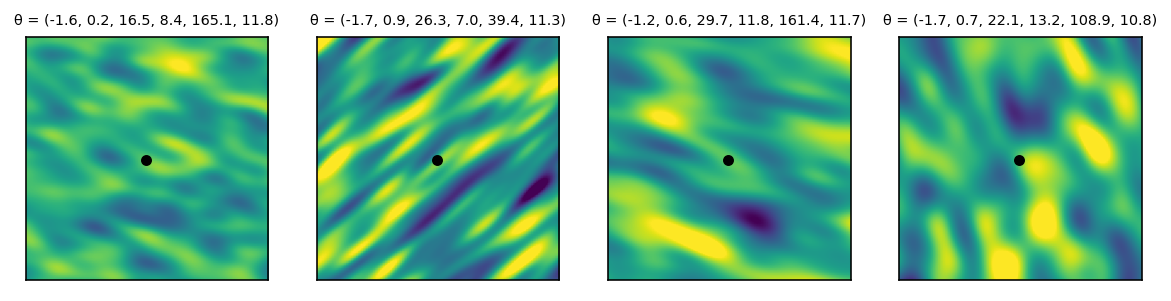

In [91]:
plt.rcParams.update({'font.size': 6})
visualize_multiple_m(loghk_pos_final[[0,2,6,8],:,:],vmin = -4, vmax = 0,theta = theta_pos_MC[:,[0,2,6,8]].T,head = 4)

In [92]:
visualize_ensemble_d(drawdown_pos_final[:,:num_sample],d_obs,ymin = 5)

In [93]:
visualize_mean_var_MC(loghk_pos_final[:num_sample,:,:],32,36,vmin = -4, vmax = 0,vmin_var = 0, vmax_var = 1,rect = True)